In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 13:54:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   27C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
namestrain_label = []
namestrain_gt_label = []
cls_label_label = []

train_label = './train_test/train_label.txt'

with open(train_label, "r") as file:
    lines = file.readlines()
    for row in lines:
        if 'benign' in row:
            namestrain_label.append("./Dataset_BUSI_with_GT/benign/" + row[:-1])
            namestrain_gt_label.append("./Dataset_BUSI_with_GT/benign/" + row[:-5] + "_mask.png")
            cls_label_label.append(0)
        else:
            namestrain_label.append("./Dataset_BUSI_with_GT/malignant/" + row[:-1])
            namestrain_gt_label.append("./Dataset_BUSI_with_GT/malignant/" + row[:-5] + "_mask.png")
            cls_label_label.append(1)


namestrain_unlabel = []
namestrain_gt_unlabel = []
cls_label_unlabel = []

train_unlabel = './train_test/train_unlabel.txt'

with open(train_unlabel, "r") as file:
    lines = file.readlines()
    for row in lines:
        if 'benign' in row:
            namestrain_unlabel.append("./Dataset_BUSI_with_GT/benign/" + row[:-1])
            namestrain_gt_unlabel.append("./Dataset_BUSI_with_GT/benign/" + row[:-5] + "_mask.png")
            cls_label_unlabel.append(0)
        else:
            namestrain_unlabel.append("./Dataset_BUSI_with_GT/malignant/" + row[:-1])
            namestrain_gt_unlabel.append("./Dataset_BUSI_with_GT/malignant/" + row[:-5] + "_mask.png")
            cls_label_unlabel.append(1)

namesval= []
namesval_gt = []
cls_label_val = []

test = './train_test/test.txt'

with open(test, "r") as file:
    lines = file.readlines()
    for row in lines:
        if 'benign' in row:
            namesval.append("./Dataset_BUSI_with_GT/benign/" + row[:-1])
            namesval_gt.append("./Dataset_BUSI_with_GT/benign/" + row[:-5] + "_mask.png")
            cls_label_val.append(0)
        else:
            namesval.append("./Dataset_BUSI_with_GT/malignant/" + row[:-1])
            namesval_gt.append("./Dataset_BUSI_with_GT/malignant/" + row[:-5] + "_mask.png")
            cls_label_val.append(1)

namestrain = namestrain_label + namestrain_unlabel
namestrain_gt = namestrain_gt_label + namestrain_gt_unlabel
cls_label = cls_label_label


In [6]:
print(namestrain)

['./Dataset_BUSI_with_GT/benign/benign (186).png', './Dataset_BUSI_with_GT/benign/benign (376).png', './Dataset_BUSI_with_GT/benign/benign (340).png', './Dataset_BUSI_with_GT/benign/benign (316).png', './Dataset_BUSI_with_GT/benign/benign (406).png', './Dataset_BUSI_with_GT/benign/benign (407).png', './Dataset_BUSI_with_GT/benign/benign (218).png', './Dataset_BUSI_with_GT/benign/benign (375).png', './Dataset_BUSI_with_GT/benign/benign (26).png', './Dataset_BUSI_with_GT/benign/benign (40).png', './Dataset_BUSI_with_GT/benign/benign (281).png', './Dataset_BUSI_with_GT/benign/benign (382).png', './Dataset_BUSI_with_GT/benign/benign (174).png', './Dataset_BUSI_with_GT/benign/benign (222).png', './Dataset_BUSI_with_GT/benign/benign (333).png', './Dataset_BUSI_with_GT/benign/benign (372).png', './Dataset_BUSI_with_GT/benign/benign (100).png', './Dataset_BUSI_with_GT/benign/benign (82).png', './Dataset_BUSI_with_GT/benign/benign (284).png', './Dataset_BUSI_with_GT/benign/benign (296).png', '.

In [7]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_masks(directory):
    image_paths = []
    mask_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".png") and not "_mask" in filename:
            image_paths.append(os.path.join(directory, filename))
            mask_paths.append(os.path.join(directory, filename[:-4] + "_mask.png"))
    return image_paths, mask_paths

# Load benign and malignant images and masks
benign_images, benign_masks = load_images_and_masks("./Dataset_BUSI_with_GT/benign/")
malignant_images, malignant_masks = load_images_and_masks("./Dataset_BUSI_with_GT/malignant/")

# Combine benign and malignant images and masks
images = benign_images + malignant_images
masks = benign_masks + malignant_masks

# Split the dataset into training and testing sets
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, masks, img_width, img_height, is_augment=True):
        self.images = images
        self.masks = masks
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        label = Image.open(self.masks[index]).resize((self.img_width, self.img_height))
        label = np.array(label, dtype=np.float32)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                label = cv2.warpAffine(label, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                label = cv2.flip(label, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])

        y_transform = transforms.Compose([
            ToLabel(),
        ])
        img_new = tfms(img_new)
        label = y_transform(label)

        return img_new, label

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, masks_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, masks_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))


Training samples #:  517
Test samples #:  130


In [8]:
class UNetResNet50(nn.Module):
    def __init__(self, n_classes):
        super(UNetResNet50, self).__init__()

        # Load a pretrained ResNet50 model
        resnet50 = models.resnet50(pretrained=True)

        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = nn.Sequential(*(list(resnet50.children())[0:3]))
        self.enc_features2 = nn.Sequential(*(list(resnet50.children())[3:5]))
        self.enc_features3 = nn.Sequential(*(list(resnet50.children())[5:6]))
        self.enc_features4 = nn.Sequential(*(list(resnet50.children())[6:7]))
        self.enc_features5 = nn.Sequential(*(list(resnet50.children())[7:8]))
        # Now, self.enc_features contains the encoder part of ResNet50

        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(2048, 1024)
        self.dec3 = self._make_dec_block(2048, 1024)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(1024, 512)
        self.dec2 = self._make_dec_block(1024, 512)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(512, 256)
        self.dec1 = self._make_dec_block(512, 256)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(256, 64)
        self.dec0 = self._make_dec_block(128, 64)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(64, 64)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x)  # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        # Decoder with skip connections
        x = self.upconv3(x5)
        x = self.dec3(torch.cat([x, x4], dim=1))  # Use skip connection from layer3

        x = self.upconv2(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2

        x = self.upconv1(x)
        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1

        x = self.upconv0(x)
        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1

        x = self.upconv_final(x)
        
        return self.final_conv(x)

model = UNetResNet50(2)
model = model.to(device)

# from resnetClsModel import resnet101_seg
# model = resnet101_seg(pretrained=True, class_num=2)
# model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khuang@kean.edu/anaconda3/envs/pytorch_env_new/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train loss: 0.4646650326974464
Epoch 1, Test loss: 0.5743093954192268
Epoch 2, Train loss: 0.2930422985192501
Epoch 2, Test loss: 0.342266321182251
Epoch 3, Train loss: 0.23359764073834274
Epoch 3, Test loss: 0.42337658007939655
Epoch 4, Train loss: 0.2024053353251833
Epoch 4, Test loss: 0.2031263593170378
Epoch 5, Train loss: 0.16936255178668283
Epoch 5, Test loss: 0.1690685691104995
Epoch 6, Train loss: 0.15614950702045904
Epoch 6, Test loss: 0.16406755066580242
Epoch 7, Train loss: 0.14720381706049948
Epoch 7, Test loss: 0.15349582665496403
Epoch 8, Train loss: 0.1321237019517205
Epoch 8, Test loss: 0.1319937151339319
Epoch 9, Train loss: 0.12005329335277731
Epoch 9, Test loss: 0.15159211059411368
Epoch 10, Train loss: 0.11895135993307288
Epoch 10, Test loss: 0.13294521470864615
Epoch 11, Train loss: 0.1153087266015284
Epoch 11, Test loss: 0.12926656049158838
Epoch 12, Train loss: 0.1032039647301038
Epoch 12, Test loss: 0.14402659816874397
Epoch 13, Train loss: 0.1011329681

Epoch 100, Train loss: 0.051576442677866326
Epoch 100, Test loss: 0.10410618223249912


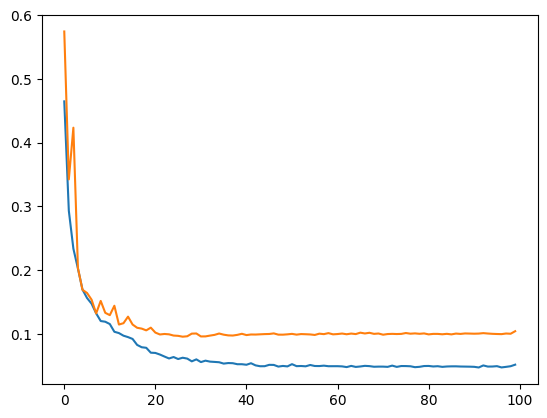

In [9]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, seg_label) in enumerate(train_loader):
        image, seg_label = image.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(image)

        # Calculate loss
        loss = loss_function(output, seg_label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, seg_label in test_loader:
            image, seg_label = image.to(device), seg_label.to(device)
            y_predict = model(image)
            loss = loss_function(y_predict, seg_label)
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/UNet_ResNet50.pt")

./Dataset_BUSI_with_GT/malignant/malignant (30).png


/tmp/ipykernel_468344/3894397167.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)


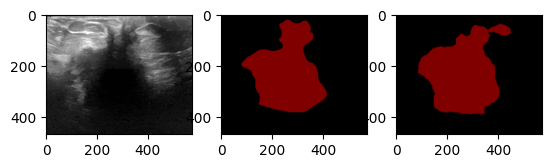

0.8069341258048539
0.9231906047409801
./Dataset_BUSI_with_GT/benign/benign (110).png


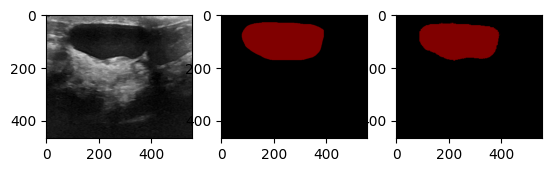

0.9063323148245707
0.9842188415316067
./Dataset_BUSI_with_GT/benign/benign (245).png


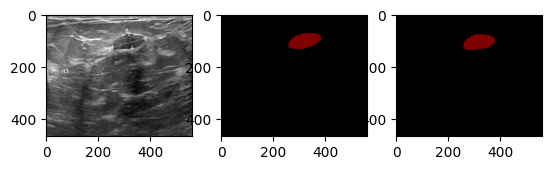

0.8025579536370904
0.9951640692301668
./Dataset_BUSI_with_GT/benign/benign (22).png


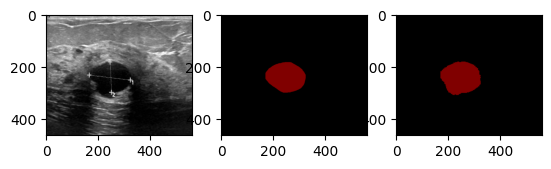

0.8938304190036291
0.9934768507256952
./Dataset_BUSI_with_GT/benign/benign (399).png


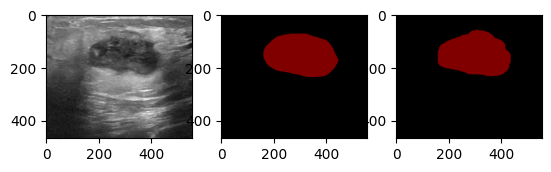

0.9072929869032531
0.9844217961744439
./Dataset_BUSI_with_GT/malignant/malignant (133).png


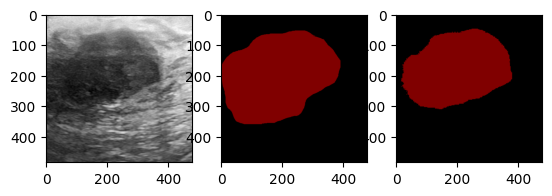

0.7766825288919103
0.8796446127072329
./Dataset_BUSI_with_GT/benign/benign (219).png


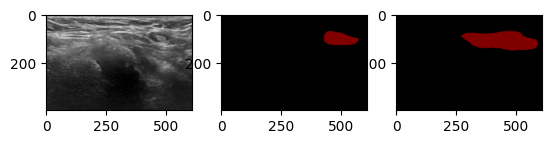

0.3300630309673883
0.9479309551600453
./Dataset_BUSI_with_GT/benign/benign (427).png


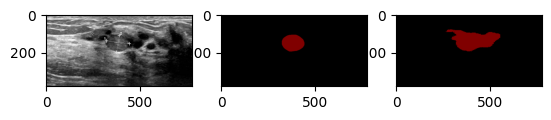

0.4256331542594014
0.9610317931415123
./Dataset_BUSI_with_GT/benign/benign (381).png


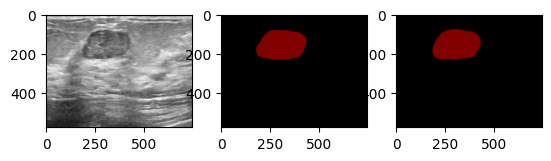

0.9430473830907402
0.9954004416976597
./Dataset_BUSI_with_GT/benign/benign (55).png


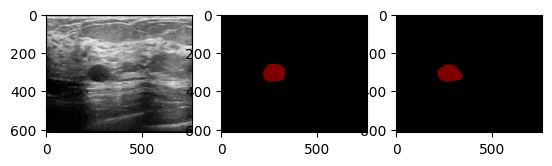

0.8642501038637308
0.9971596897607576
./Dataset_BUSI_with_GT/malignant/malignant (1).png


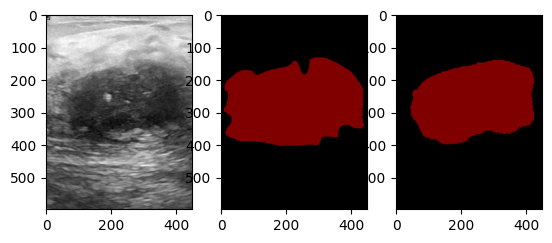

0.7902743410435719
0.9000543461542405
./Dataset_BUSI_with_GT/benign/benign (362).png


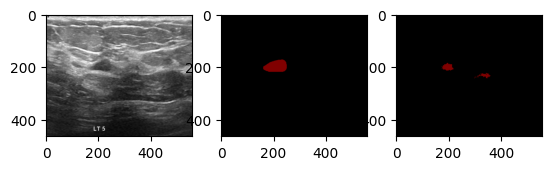

0.22662061636556854
0.9886993148158931
./Dataset_BUSI_with_GT/benign/benign (15).png


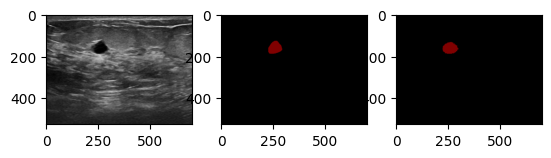

0.8235981308411215
0.998349302826409
./Dataset_BUSI_with_GT/benign/benign (14).png


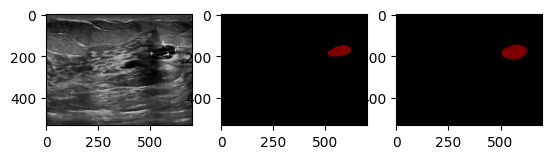

0.6639743980493752
0.9939887462787477
./Dataset_BUSI_with_GT/malignant/malignant (62).png


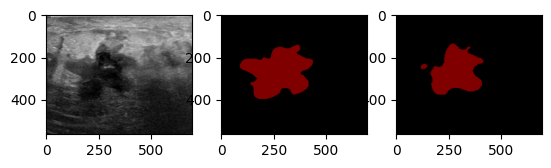

0.6951959544879899
0.9521968435244667
./Dataset_BUSI_with_GT/benign/benign (435).png


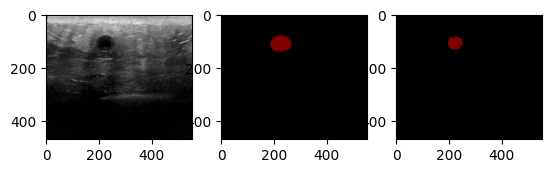

0.5651948051948052
0.9934790738259217
./Dataset_BUSI_with_GT/benign/benign (191).png


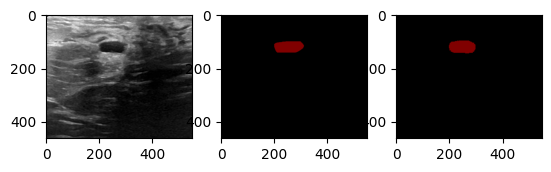

0.8231111111111111
0.9968221396262421
./Dataset_BUSI_with_GT/malignant/malignant (145).png


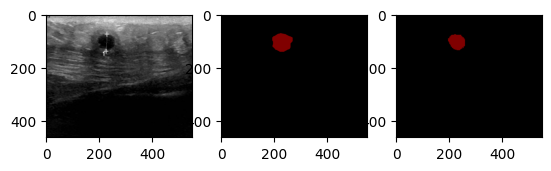

0.7101167315175098
0.9952543992356079
./Dataset_BUSI_with_GT/benign/benign (335).png


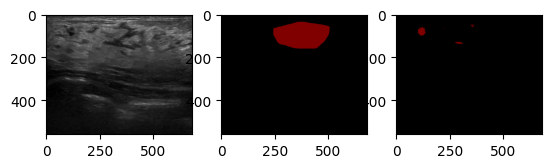

0.012828140105599762
0.9301955649508064
./Dataset_BUSI_with_GT/benign/benign (259).png


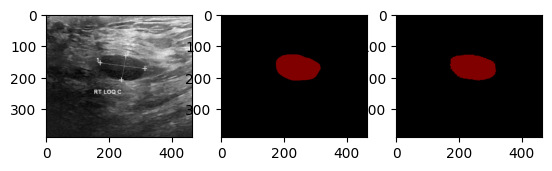

0.9221298861188058
0.9955964771817454
./Dataset_BUSI_with_GT/benign/benign (45).png


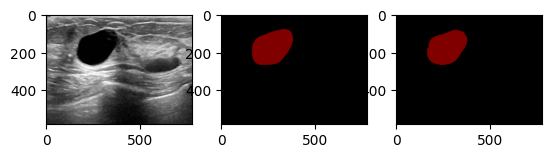

0.9288995983935743
0.9947383187347237
./Dataset_BUSI_with_GT/benign/benign (344).png


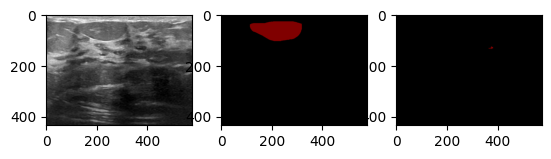

0.0
0.9507608486943164
./Dataset_BUSI_with_GT/benign/benign (199).png


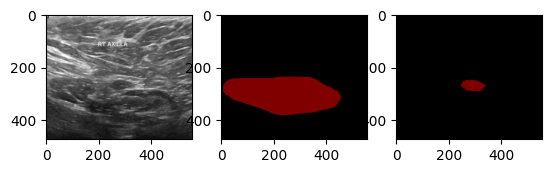

0.06195451751690227
0.8238756135464911
./Dataset_BUSI_with_GT/benign/benign (240).png


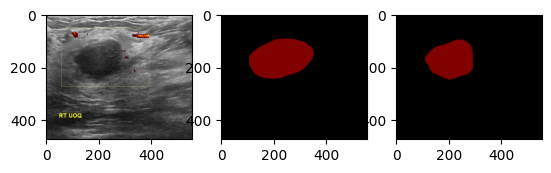

0.7244111197566669
0.9678688362349798
./Dataset_BUSI_with_GT/malignant/malignant (140).png


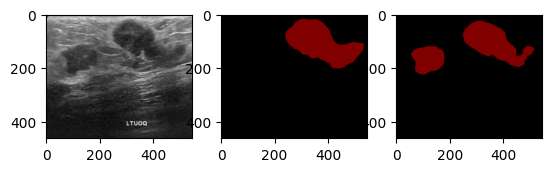

0.5683323604801664
0.9261774969184563
./Dataset_BUSI_with_GT/benign/benign (385).png


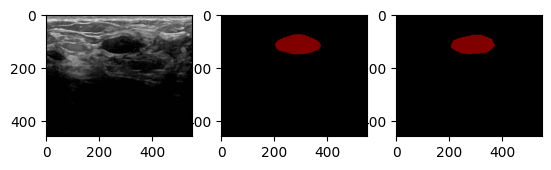

0.9079606978143172
0.9962269114105103
./Dataset_BUSI_with_GT/benign/benign (125).png


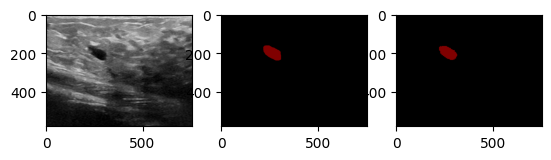

0.8476302389345868
0.9982017381656805
./Dataset_BUSI_with_GT/benign/benign (72).png


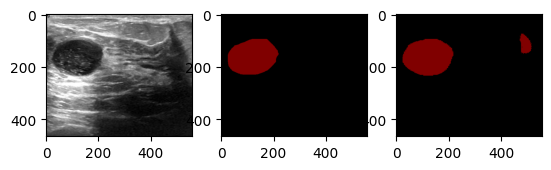

0.8261353333882799
0.9823441776379113
./Dataset_BUSI_with_GT/malignant/malignant (56).png


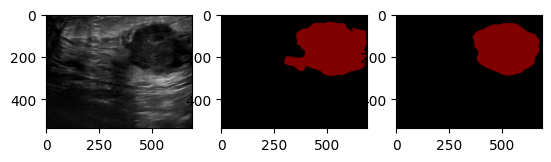

0.8249126957305396
0.9602287629782688
./Dataset_BUSI_with_GT/benign/benign (196).png


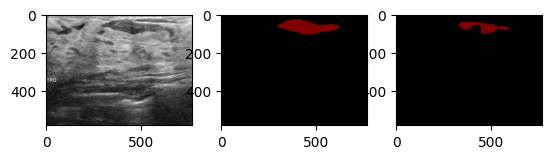

0.5125253450192949
0.9829233532824372
./Dataset_BUSI_with_GT/malignant/malignant (120).png


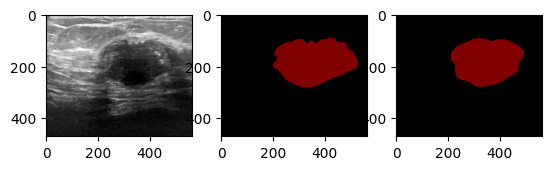

0.8498033164540456
0.9694173769127968
./Dataset_BUSI_with_GT/benign/benign (346).png


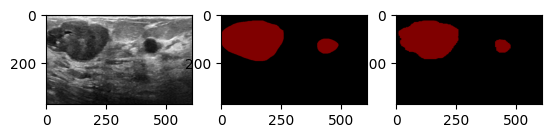

0.8634361233480177
0.9730512432743845
./Dataset_BUSI_with_GT/benign/benign (139).png


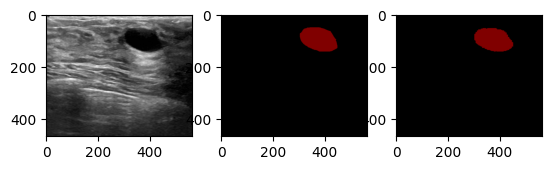

0.9260357771804616
0.9968519840784558
./Dataset_BUSI_with_GT/malignant/malignant (59).png


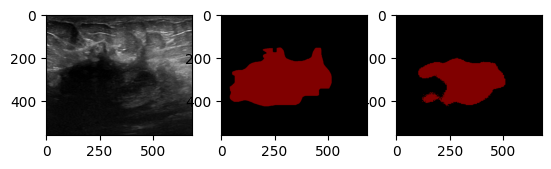

0.6264093002851503
0.8953441929914037
./Dataset_BUSI_with_GT/malignant/malignant (8).png


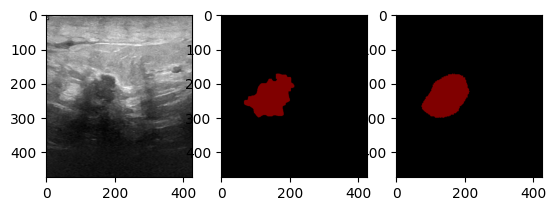

0.8244543534381601
0.9882487863887013
./Dataset_BUSI_with_GT/benign/benign (319).png


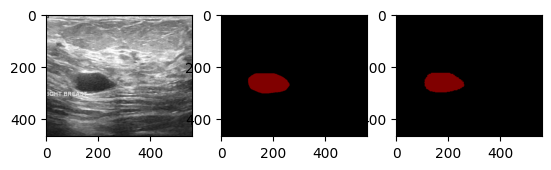

0.8954468802698144
0.9958256268490612
./Dataset_BUSI_with_GT/benign/benign (303).png


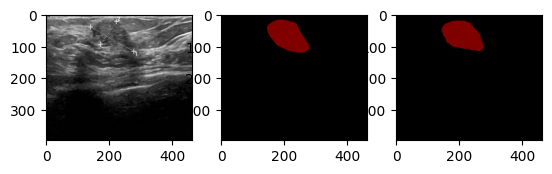

0.8774703557312253
0.9931156614431487
./Dataset_BUSI_with_GT/benign/benign (434).png


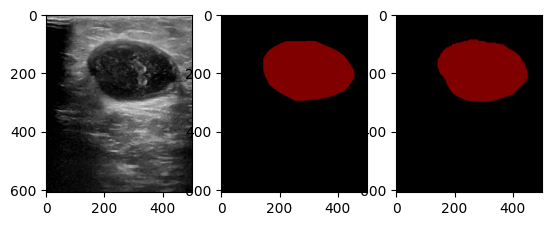

0.9438169595288374
0.9886891946706605
./Dataset_BUSI_with_GT/benign/benign (28).png


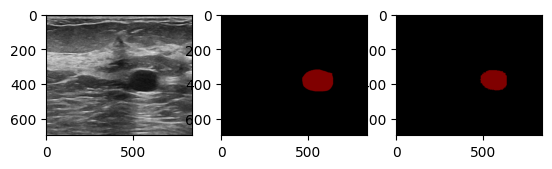

0.7772306374779211
0.9927086709354169
./Dataset_BUSI_with_GT/benign/benign (294).png


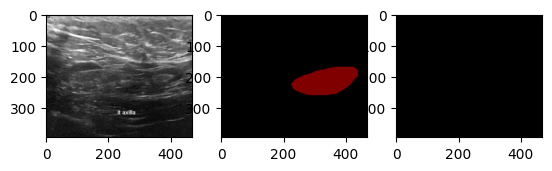

0.0
0.9244423278819824
./Dataset_BUSI_with_GT/benign/benign (122).png


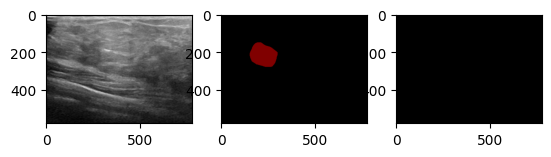

0.0
0.9682510893465712
./Dataset_BUSI_with_GT/benign/benign (129).png


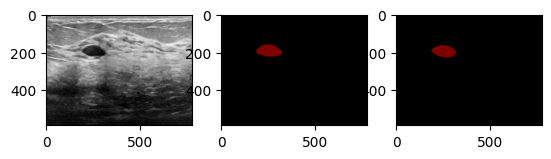

0.8581425863828547
0.9978331503499696
./Dataset_BUSI_with_GT/malignant/malignant (181).png


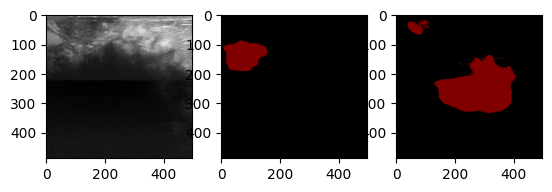

0.0
0.8028498862024607
./Dataset_BUSI_with_GT/benign/benign (171).png


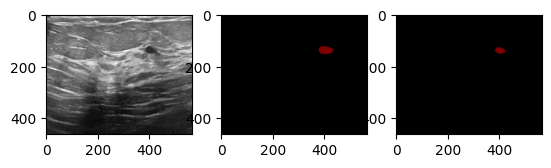

0.533235938641344
0.9975547970366743
./Dataset_BUSI_with_GT/malignant/malignant (89).png


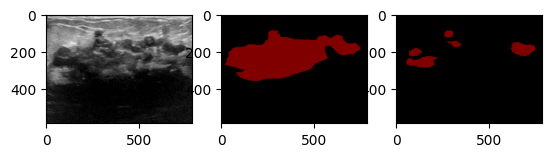

0.1752523315529031
0.8001065578416369
./Dataset_BUSI_with_GT/benign/benign (395).png


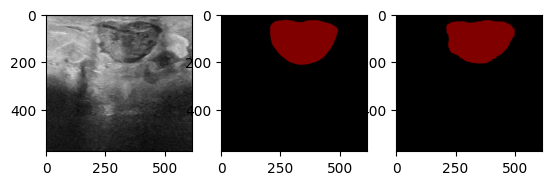

0.9158908804594507
0.9884584829514761
./Dataset_BUSI_with_GT/malignant/malignant (44).png


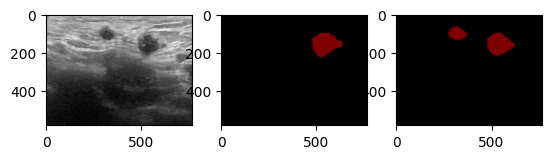

0.6216982140947492
0.9836254521805343
./Dataset_BUSI_with_GT/benign/benign (264).png


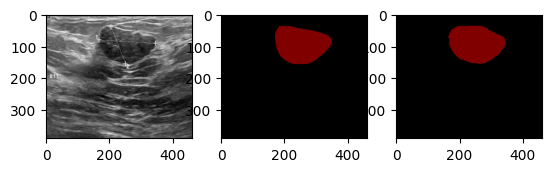

0.9121965486984498
0.9909056759245796
./Dataset_BUSI_with_GT/benign/benign (33).png


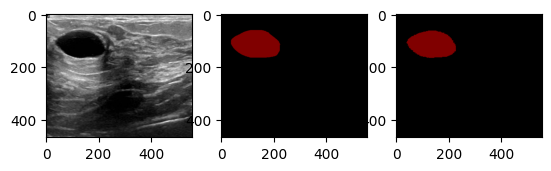

0.9255441008018328
0.9952373974208675
./Dataset_BUSI_with_GT/benign/benign (44).png


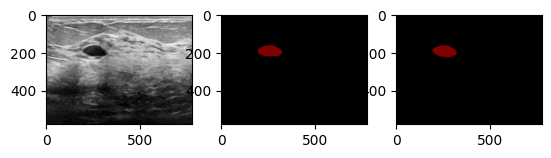

0.9041673169970345
0.998619812213538
./Dataset_BUSI_with_GT/malignant/malignant (138).png


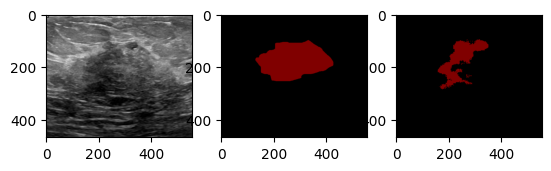

0.35334288588762536
0.914493150905822
./Dataset_BUSI_with_GT/benign/benign (180).png


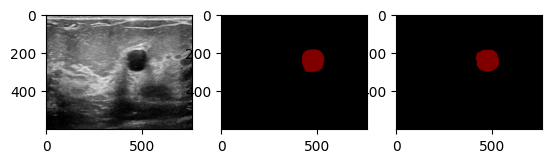

0.9165966739459096
0.9977779617666211
./Dataset_BUSI_with_GT/malignant/malignant (54).png


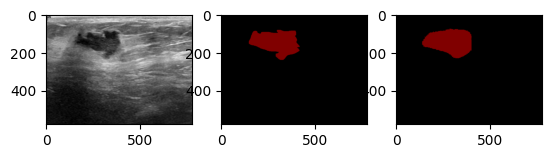

0.8388198555721814
0.9883376914984007
./Dataset_BUSI_with_GT/malignant/malignant (203).png


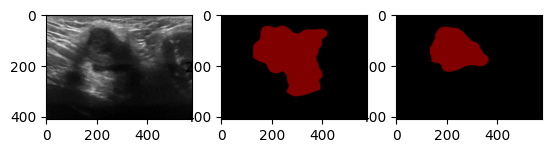

0.5078882589885126
0.8742854148405046
./Dataset_BUSI_with_GT/benign/benign (239).png


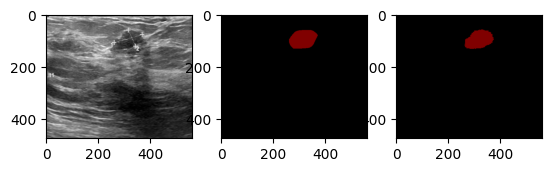

0.8513309134906231
0.9962083077789479
./Dataset_BUSI_with_GT/benign/benign (23).png


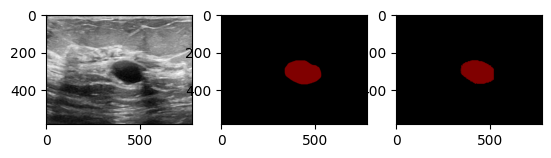

0.8933792815371763
0.9953277336304791
./Dataset_BUSI_with_GT/benign/benign (398).png


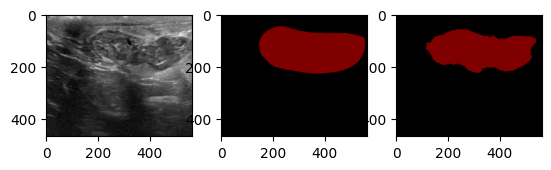

0.7843476217649625
0.9408735746431431
./Dataset_BUSI_with_GT/benign/benign (277).png


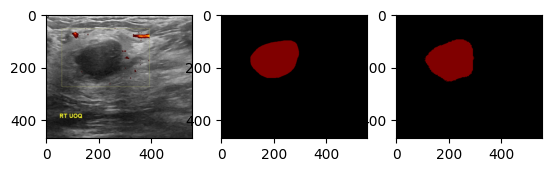

0.8697782132359491
0.9878789888655828
./Dataset_BUSI_with_GT/benign/benign (235).png


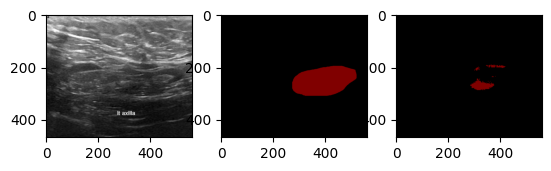

0.10215511447645503
0.9228675904541955
./Dataset_BUSI_with_GT/benign/benign (334).png


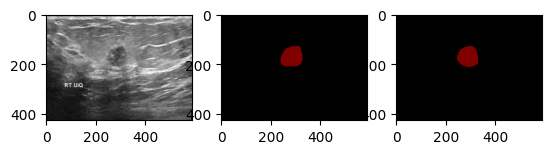

0.8567819358913628
0.9963053183862348
./Dataset_BUSI_with_GT/benign/benign (217).png


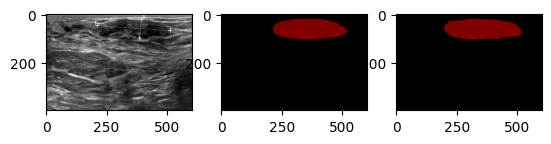

0.8933657673595754
0.9889701677577554
./Dataset_BUSI_with_GT/malignant/malignant (52).png


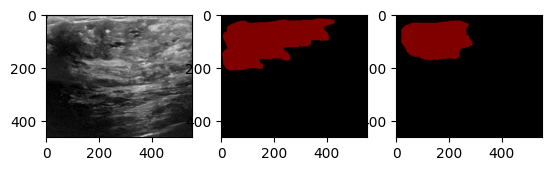

0.5957095399861114
0.9035264506189427
./Dataset_BUSI_with_GT/benign/benign (365).png


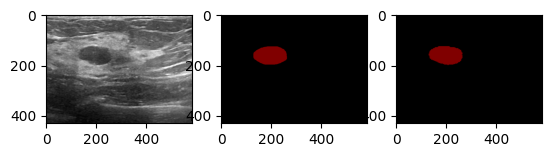

0.8965392499698541
0.9964750397482406
./Dataset_BUSI_with_GT/benign/benign (409).png


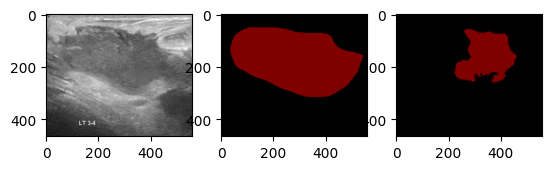

0.31694718938152827
0.7149668631941964
./Dataset_BUSI_with_GT/benign/benign (273).png


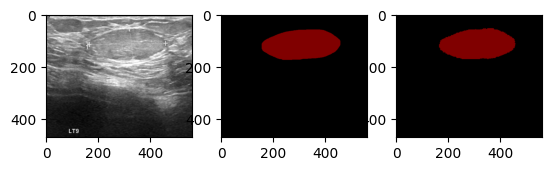

0.9297588470319634
0.9916771283768075
./Dataset_BUSI_with_GT/benign/benign (153).png


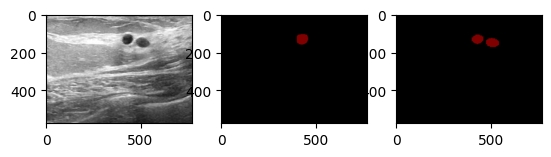

0.4203161911684536
0.9927634041491329
./Dataset_BUSI_with_GT/benign/benign (400).png


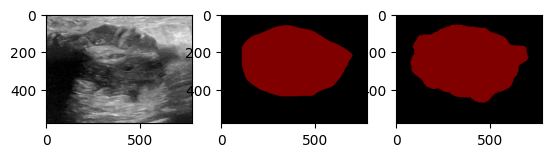

0.9011282999374677
0.9364448545603254
./Dataset_BUSI_with_GT/malignant/malignant (33).png


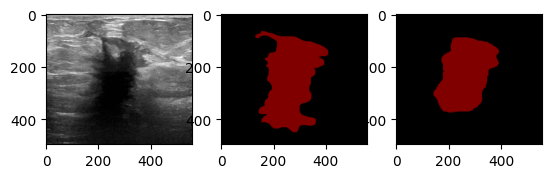

0.7153277816041576
0.9211272736735278
./Dataset_BUSI_with_GT/benign/benign (369).png


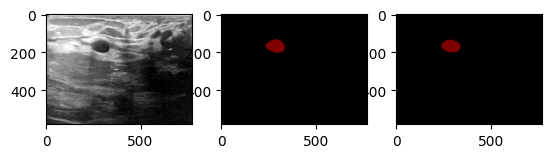

0.9145454545454546
0.9989402528060752
./Dataset_BUSI_with_GT/malignant/malignant (24).png


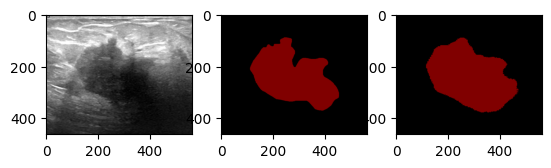

0.8414396139720006
0.9498671123787127
./Dataset_BUSI_with_GT/benign/benign (160).png


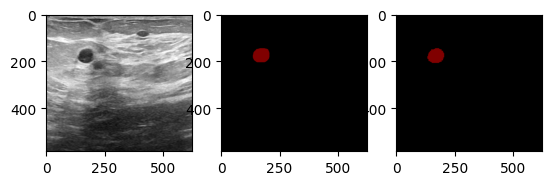

0.8872832369942196
0.9988138128589322
./Dataset_BUSI_with_GT/benign/benign (35).png


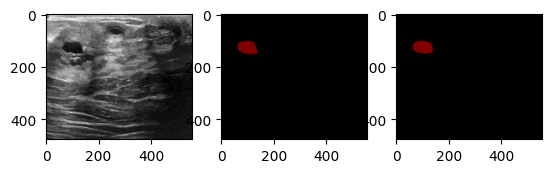

0.8714372346876895
0.9983803317263983
./Dataset_BUSI_with_GT/benign/benign (187).png


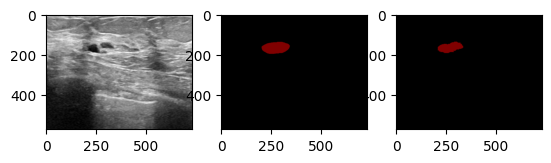

0.7251364463311097
0.9956232784613639
./Dataset_BUSI_with_GT/malignant/malignant (172).png


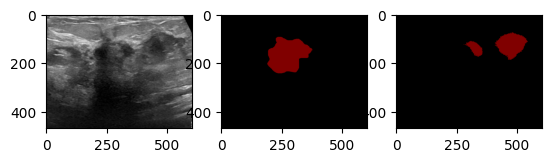

0.08971004623490197
0.9092393732020655
./Dataset_BUSI_with_GT/benign/benign (284).png


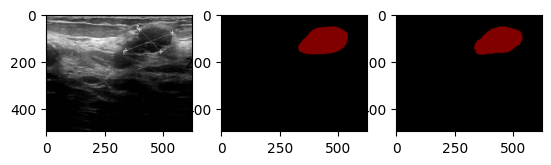

0.9050167224080268
0.9936682158843403
./Dataset_BUSI_with_GT/benign/benign (37).png


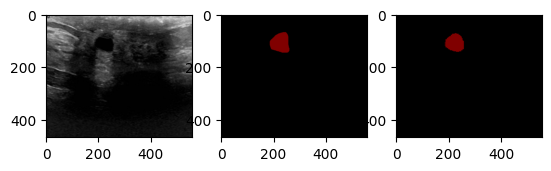

0.8395088796316598
0.9971500543124895
./Dataset_BUSI_with_GT/benign/benign (241).png


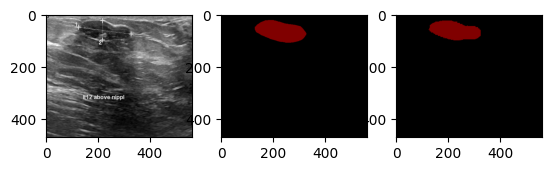

0.8705949377390738
0.9937402807031358
./Dataset_BUSI_with_GT/benign/benign (324).png


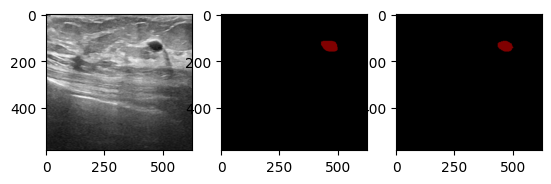

0.8366824990865912
0.9987674677666626
./Dataset_BUSI_with_GT/benign/benign (7).png


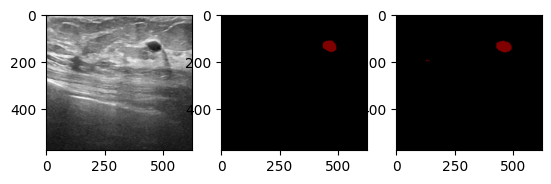

0.7865420560747663
0.998407554494545
./Dataset_BUSI_with_GT/malignant/malignant (36).png


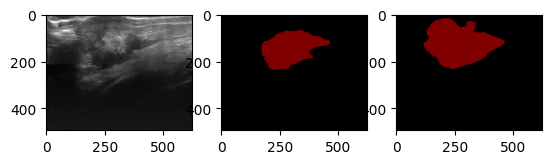

0.6262176099828102
0.9367017185736772
./Dataset_BUSI_with_GT/benign/benign (169).png


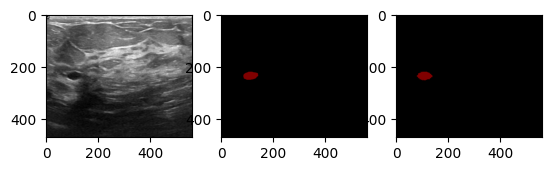

0.8188824662813102
0.99892298173652
./Dataset_BUSI_with_GT/malignant/malignant (64).png


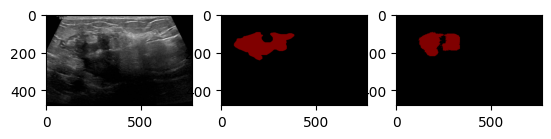

0.611138032579118
0.9704804566021398
./Dataset_BUSI_with_GT/benign/benign (215).png


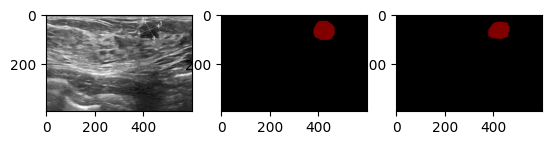

0.8634468380820014
0.996621244035593
./Dataset_BUSI_with_GT/malignant/malignant (7).png


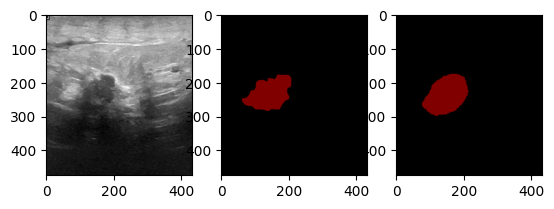

0.7439948926661879
0.9835861751387859
./Dataset_BUSI_with_GT/benign/benign (157).png


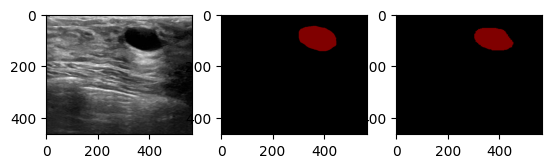

0.8757286698463169
0.9944549538898084
./Dataset_BUSI_with_GT/benign/benign (336).png


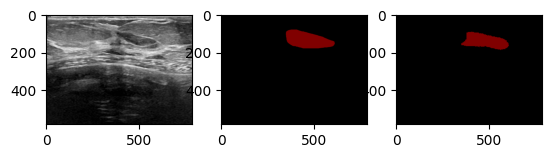

0.7400988810824877
0.9887480454404124
./Dataset_BUSI_with_GT/benign/benign (428).png


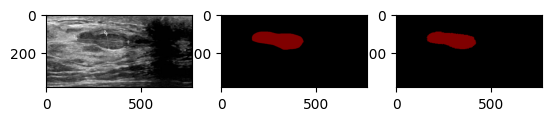

0.8828983897834536
0.9924097647350976
./Dataset_BUSI_with_GT/benign/benign (417).png


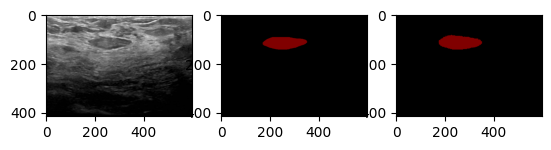

0.8640020110608346
0.995534645701787
./Dataset_BUSI_with_GT/benign/benign (436).png


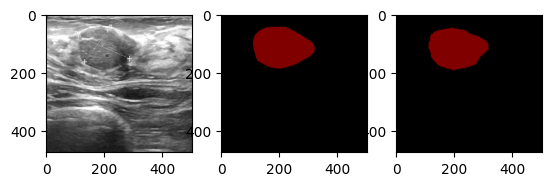

0.9010085600474617
0.9892194234975956
./Dataset_BUSI_with_GT/malignant/malignant (93).png


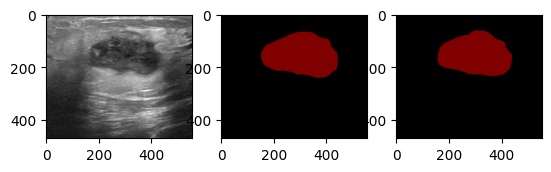

0.9329213778595845
0.98865723140404
./Dataset_BUSI_with_GT/benign/benign (141).png


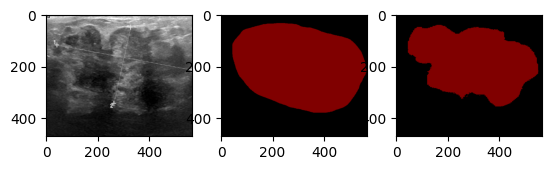

0.7716747090959151
0.8037209128506652
./Dataset_BUSI_with_GT/benign/benign (420).png


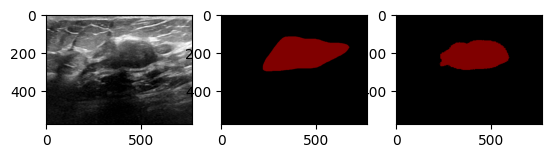

0.7385245614649347
0.9625331747966868
./Dataset_BUSI_with_GT/benign/benign (243).png


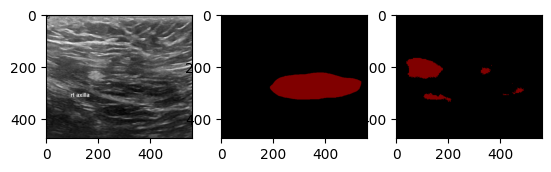

0.015579994763026971
0.8580024021937014
./Dataset_BUSI_with_GT/benign/benign (265).png


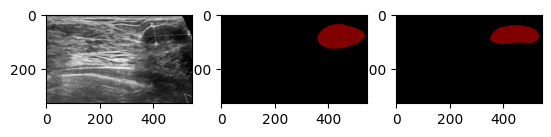

0.7823689258312021
0.9838534656048576
./Dataset_BUSI_with_GT/malignant/malignant (55).png


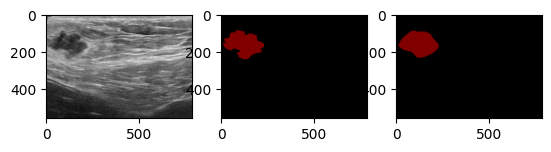

0.8649839743589743
0.9927368080750026
./Dataset_BUSI_with_GT/benign/benign (64).png


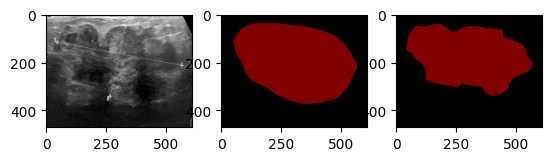

0.8034135166093929
0.8586349483534044
./Dataset_BUSI_with_GT/malignant/malignant (45).png


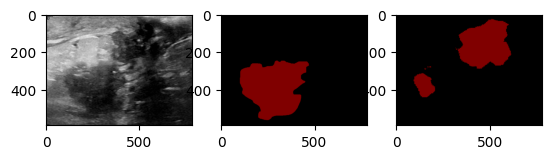

0.08877782551994995
0.7317205792598347
./Dataset_BUSI_with_GT/malignant/malignant (128).png


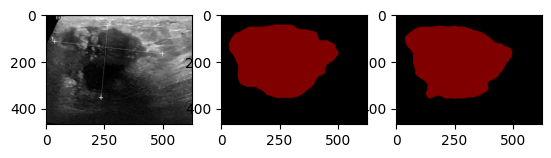

0.8889840980634454
0.9365374005496517
./Dataset_BUSI_with_GT/benign/benign (387).png


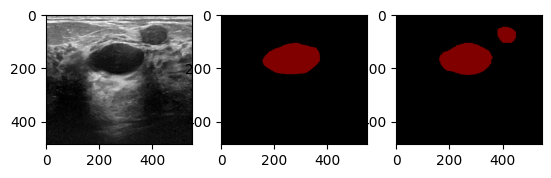

0.7652371187993543
0.9784133122587996
./Dataset_BUSI_with_GT/benign/benign (99).png


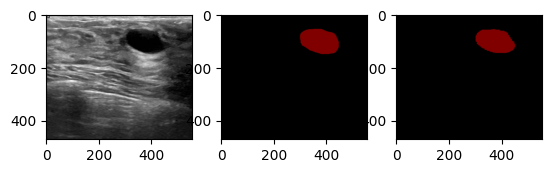

0.904563948346011
0.9956961712277679
./Dataset_BUSI_with_GT/malignant/malignant (28).png


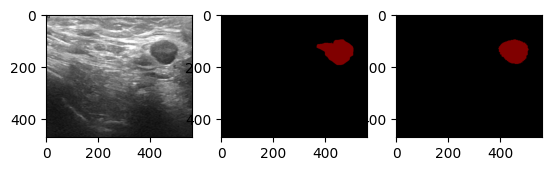

0.8498571114530666
0.9946725531184675
./Dataset_BUSI_with_GT/benign/benign (24).png


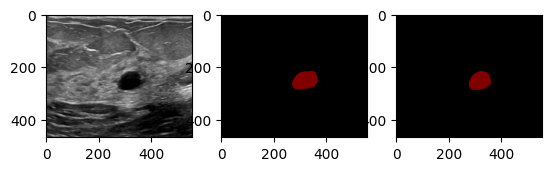

0.8202005730659025
0.996063856479739
./Dataset_BUSI_with_GT/benign/benign (30).png


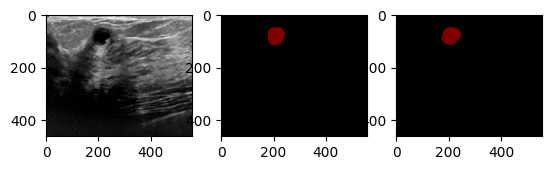

0.8902221087567016
0.9983060662525064
./Dataset_BUSI_with_GT/benign/benign (411).png


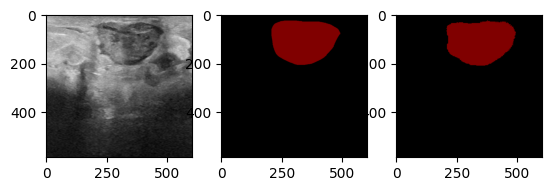

0.9142276517717409
0.9883144780180438
./Dataset_BUSI_with_GT/benign/benign (402).png


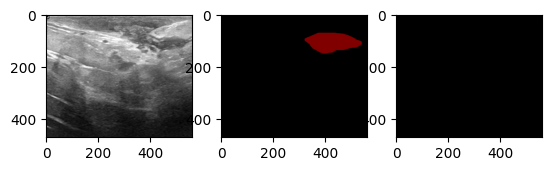

0.0
0.9541900885184468
./Dataset_BUSI_with_GT/benign/benign (364).png


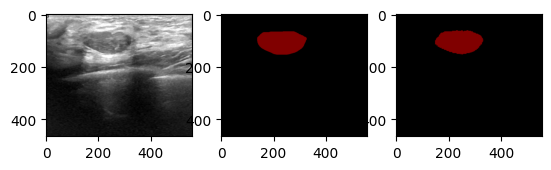

0.8363995206879538
0.9906085239480616
./Dataset_BUSI_with_GT/malignant/malignant (210).png


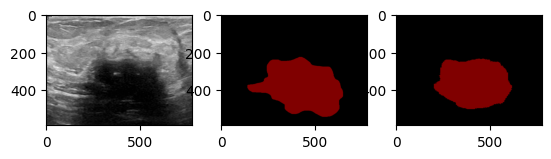

0.7710788064269319
0.9360514666004098
./Dataset_BUSI_with_GT/benign/benign (144).png


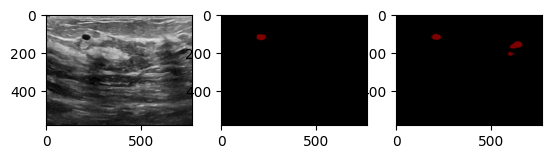

0.31810394060536834
0.9946395621860171
./Dataset_BUSI_with_GT/malignant/malignant (157).png


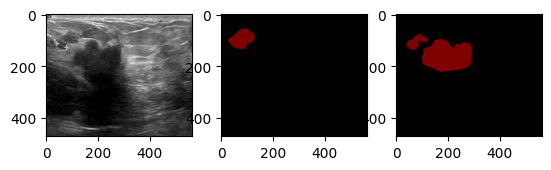

0.10228937345666095
0.9185068389057751
./Dataset_BUSI_with_GT/benign/benign (213).png


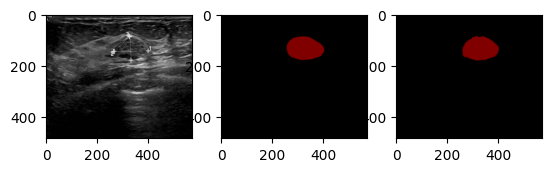

0.9145604395604395
0.9965250231851347
./Dataset_BUSI_with_GT/benign/benign (290).png


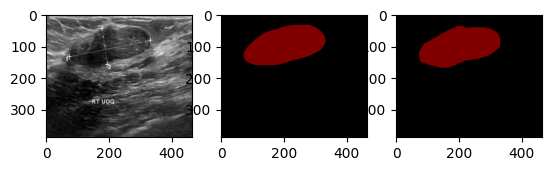

0.9187855939680757
0.9871815972046387
./Dataset_BUSI_with_GT/malignant/malignant (188).png


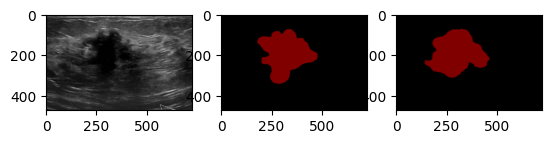

0.71360106995579
0.9492888999986844
./Dataset_BUSI_with_GT/benign/benign (253).png


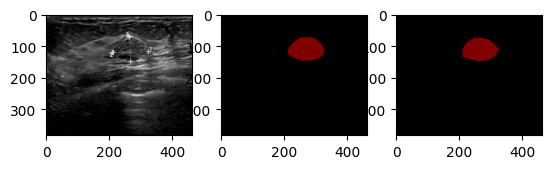

0.8854928971157985
0.9953376412437631
./Dataset_BUSI_with_GT/malignant/malignant (152).png


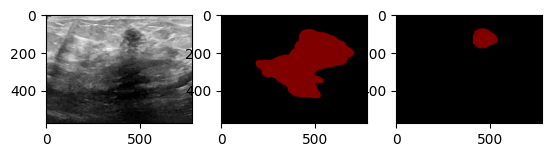

0.10343687012248695
0.8007932625506125
./Dataset_BUSI_with_GT/malignant/malignant (190).png


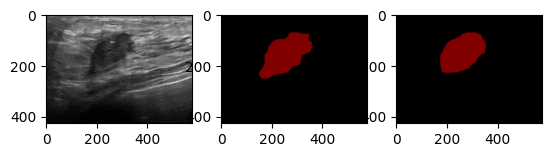

0.8497824494895102
0.9845862102499271
./Dataset_BUSI_with_GT/benign/benign (285).png


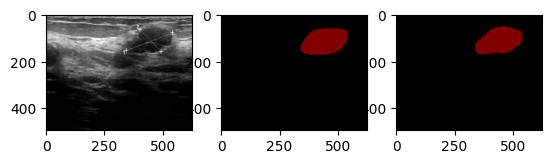

0.8907377178663578
0.9928897935127504
./Dataset_BUSI_with_GT/benign/benign (108).png


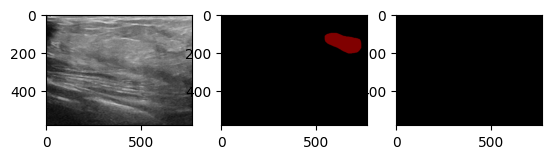

0.0
0.9690386497392517
./Dataset_BUSI_with_GT/benign/benign (173).png


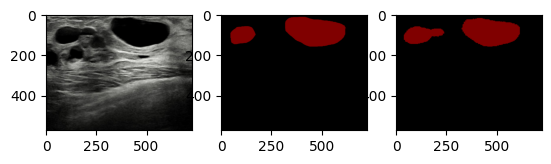

0.8471369694843914
0.9815213790727564
./Dataset_BUSI_with_GT/benign/benign (432).png


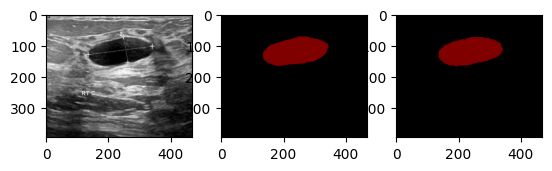

0.9424850786760717
0.9950377435777401
./Dataset_BUSI_with_GT/malignant/malignant (150).png


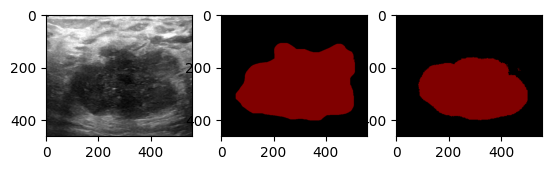

0.7369992972593113
0.8522543466698834
./Dataset_BUSI_with_GT/benign/benign (238).png


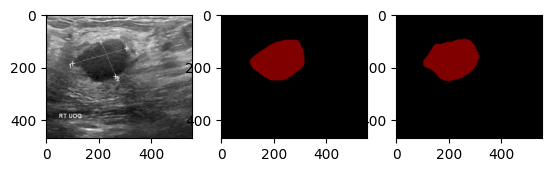

0.8809807661738992
0.9874473480165133
./Dataset_BUSI_with_GT/malignant/malignant (202).png


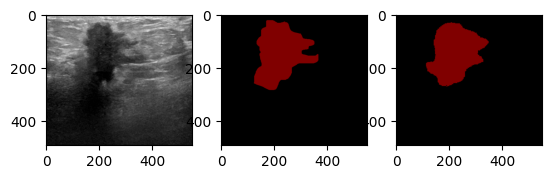

0.8254245561750122
0.9714402199040022
./Dataset_BUSI_with_GT/malignant/malignant (46).png


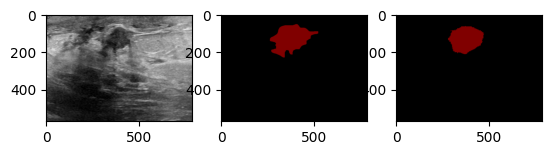

0.7585817260861095
0.9855492273174645
./Dataset_BUSI_with_GT/benign/benign (67).png


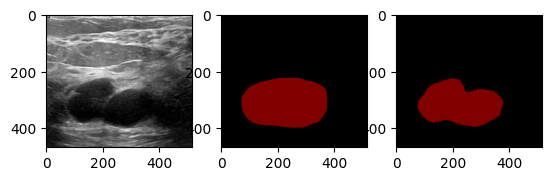

0.8023399986473996
0.9573086117995335
./Dataset_BUSI_with_GT/benign/benign (156).png


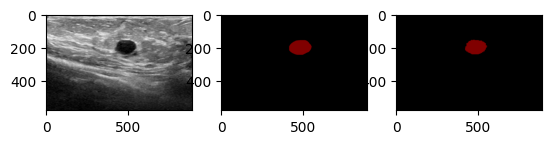

0.8916055419722901
0.9978997029185049
./Dataset_BUSI_with_GT/malignant/malignant (148).png


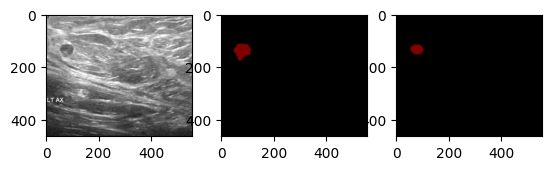

0.5164565826330533
0.9946044781659132
./Dataset_BUSI_with_GT/benign/benign (220).png


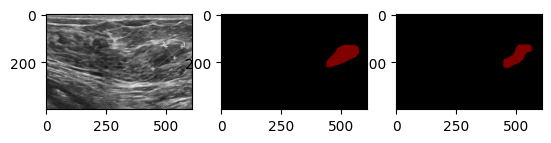

0.6955043445409897
0.9897386278279247
./Dataset_BUSI_with_GT/malignant/malignant (165).png


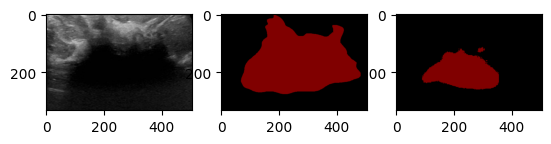

0.34273481326569544
0.675645897981242
./Dataset_BUSI_with_GT/benign/benign (76).png


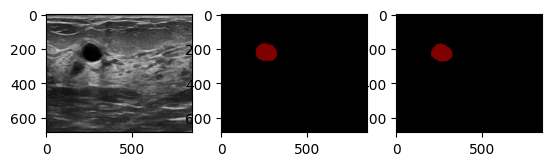

0.9088249174138745
0.9983089745138302
./Dataset_BUSI_with_GT/malignant/malignant (131).png


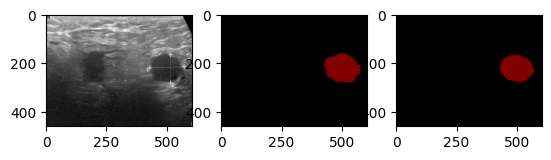

0.8575997673911463
0.9926531806214982
average tumor IoU: 0.7000305329195368
average background IoU: 0.9606711846404362


In [10]:
# Step 4: IoU and segmentation results
model = torch.load("./save_models/UNet_ResNet50.pt")
model = model.to(device)
from utility import VOCPalette

total_tumor_IoU = []
total_background_IoU = []
palette = VOCPalette(nb_class=2)

for test_image in images_test:
    image = Image.open(test_image)
    print(test_image)
    label = Image.open(test_image[:-4] + "_mask.png")
    
    image_resize = image.convert("RGB").resize((224, 224))
    image_resize = np.array(image_resize)
    img_new = np.float32(image_resize)
    img_new = img_new /127.5 -1

  
    tfms = transforms.Compose([
            transforms.ToTensor()
        ])

    image_tensor = tfms(img_new).unsqueeze(0).to(device)

    predict = model(image_tensor).squeeze(0)

    predict_label = torch.argmax(predict, 0)

    predict_label = predict_label.cpu().numpy().astype('uint8')

    # resize the predict result to original size
    
    PIL_predicr_pal_U = palette.genlabelpal(predict_label)
    PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(PIL_img_pal)
    plt.show()

    # Compute IoU between thresh1 and label

    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    # IoU

    print(compute_iou(np.array(PIL_img_pal), np.array(label)))
    print(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
    total_tumor_IoU.append(compute_iou(np.array(PIL_img_pal), np.array(label)))
    total_background_IoU.append(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
print("average tumor IoU:", np.mean(total_tumor_IoU))
print("average background IoU:", np.mean(total_background_IoU))